In [14]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

In [15]:
import pandas as pd

df = pd.read_csv('gs://rob_buck/loan.csv')
df.head()

/var/tmp/ipykernel_13561/2369202826.py:3: DtypeWarning: Columns (19,47,55,112,123,124,125,128,129,130,133,139,140,141) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('gs://rob_buck/loan.csv')


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,NaN,NaN,2500,2500,2500.0,36 months,13.56,84.92,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,30000,30000,30000.0,60 months,18.94,777.23,D,D2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,5000,5000,5000.0,36 months,17.97,180.69,D,D1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,4000,4000,4000.0,36 months,18.94,146.51,D,D2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,30000,30000,30000.0,60 months,16.14,731.78,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
df.shape

(2260668, 145)

In [17]:
df['is_default'] = df['loan_status'].map({
    'Fully Paid': 0,
    'Current': 0,
    'In Grace Period': 0,
    'Does not meet the credit policy. Status:Fully Paid': 0,
    
    'Charged Off': 1,
    'Default': 1,
    'Late (31-120 days)': 1,
    'Late (16-30 days)': 1,
    'Does not meet the credit policy. Status:Charged Off': 1
})

In [18]:
key_features = [
    'grade', 'int_rate', 'home_ownership', 'revol_util', 
    'loan_amnt', 'annual_inc', 'dti',
    'term', 'verification_status', 'inq_last_6mths', 
    'open_acc', 'pub_rec', 'total_acc', 'acc_now_delinq',
    'is_default'
]

In [19]:
df = df[key_features]

In [20]:
df.shape

(2260668, 15)

In [21]:
df.isnull().sum() 

grade                     0
int_rate                  0
home_ownership            0
revol_util             1802
loan_amnt                 0
annual_inc                4
dti                    1711
term                      0
verification_status       0
inq_last_6mths           30
open_acc                 29
pub_rec                  29
total_acc                29
acc_now_delinq           29
is_default                0
dtype: int64

In [22]:
df['revol_util'] = df['revol_util'].fillna(df['annual_inc'].mean())
df['dti'] = df['dti'].fillna(df['dti'].median())
df['annual_inc'] = df['annual_inc'].fillna(df['annual_inc'].median())

df.dropna(axis=1, inplace=True)

In [23]:
df.isnull().sum()

grade                  0
int_rate               0
home_ownership         0
revol_util             0
loan_amnt              0
annual_inc             0
dti                    0
term                   0
verification_status    0
is_default             0
dtype: int64

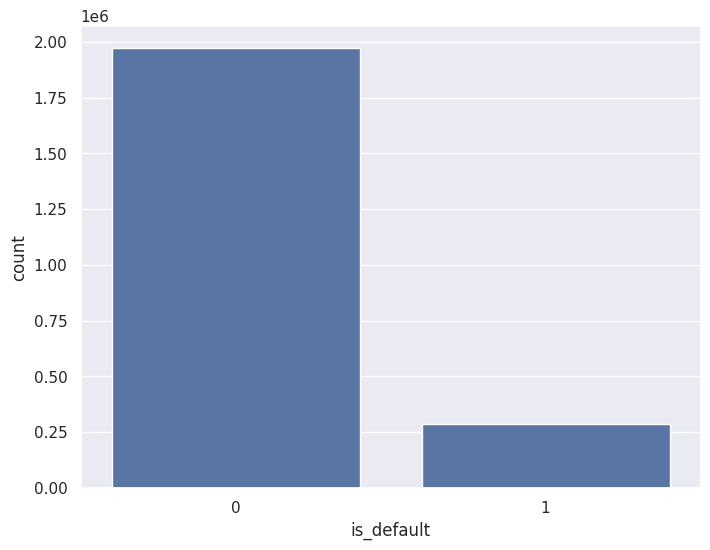

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style = "darkgrid")
plt.figure(figsize=(8, 6))

sns.countplot(x=df['is_default'], data=df)
plt.show()

In [25]:
from sklearn.preprocessing import LabelEncoder

for col in ['grade', 'verification_status', 'home_ownership', 'term']:
   encoder = LabelEncoder()
   df[col] = encoder.fit_transform(df[col])

df.head()

,grade,int_rate,home_ownership,revol_util,loan_amnt,annual_inc,dti,term,verification_status,is_default
0,2,13.56,5,10.3,2500,55000.0,18.24,0,0,0
1,3,18.94,1,24.2,30000,90000.0,26.52,1,1,0
2,3,17.97,1,19.1,5000,59280.0,10.51,0,1,0
3,3,18.94,1,78.1,4000,92000.0,16.74,0,1,0
4,2,16.14,1,3.6,30000,57250.0,26.35,1,0,0


In [26]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.drop('is_default', axis=1), df['is_default'], test_size=0.2, random_state=42)

In [27]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [28]:
print(f"X_train_scaled shape: {X_train_scaled.shape}")
print(f"X_test_scaled shape: {X_test_scaled.shape}")

X_train_scaled shape: (1808534, 9)
X_test_scaled shape: (452134, 9)


In [29]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

In [30]:
param_dist = {
    'learning_rate': uniform(0.01, 0.2),
    'n_estimators': randint(300, 2000),
    'max_depth': randint(6, 20),
    'min_child_weight': randint(1, 10),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'colsample_bylevel': uniform(0.6, 0.4),
    'reg_alpha': uniform(0, 10),
    'reg_lambda': uniform(1, 10),
    'gamma': uniform(0, 5),
    'scale_pos_weight': uniform(7, 12),  # Around your 9:1 ratio
}

In [31]:
xgb_model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    use_label_encoder=False,
    random_state=42,
    n_jobs=-1,
    tree_method='hist'  
)

In [32]:
from sklearn.model_selection import StratifiedKFold

cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=100,
    cv=cv_strategy,  
    scoring='roc_auc',
    n_jobs=-1,
    random_state=42,
    return_train_score=True
)

In [ ]:
random_search.fit(X_train_scaled, y_train)

In [ ]:
model = random_search.best_estimator_

pred_proba = model.predict_proba(X_test_scaled)[:, 1]
pred_binary = model.predict(X_test_scaled)

In [ ]:
from sklearn.metrics import roc_auc_score, accuracy_score

roc_auc = roc_auc_score(y_test, pred_proba)
accuracy = accuracy_score(y_test, pred_binary)

print(f"ROC-AUC Score: {roc_auc:.4f}")
print(f"Accuracy Score: {accuracy:.4f}")

In [ ]:
feature_importance = pd.DataFrame({
    'feature': X_train_scaled.columns,
    'importance': model.feature_importances_  
}).sort_values('importance', ascending=False)  

feature_importance

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.set_theme(style="darkgrid")

sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance from Gradient Boosting Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()